In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
# !pip install tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# !pip install scikit-learn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import shutil
import pandas as pd
from scipy.spatial import distance
import matplotlib.image as mpimg
from IPython.display import display, HTML
import warnings
# Suppress specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

n_components_threshold = 0.50 ## percent variance that will be explained between componet PCAs

subcategories = [
    "process diagram",
    "2x2 matrix",
    "venn diagram",
    "conceptual diagram",
    "cycle",
    "hierarchical diagram",
    "bar chart(s)",
    "stacked bar chart(s)",
    "line graph(s)",
    "scatter plot(s)",
    "pie chart(s)",
    "mixed statistical plot (more than 1 statistical plot and type)",
    "mixed line, bar, scatter plot",
    "data structure",
    "data display",
    "data collection, data analysis, data gathering diagram",
    "heatmap",
    "data map",
    "organizational chart",
    "timeline",
    "drawing(s)",
    "photo(s)",
    "table",
    "other"
]

def load_and_preprocess_images(yearly_data, target_size=(224, 224)):
    # Generate full image paths
    image_paths = ["../" + figure_path for figure_path in yearly_data["new image path"]]
    # Load images, resize, and convert to grayscale
    images = [load_img(path, target_size=target_size, color_mode='grayscale') for path in image_paths]
    # Convert images to numpy arrays
    images_array = np.array([img_to_array(image) for image in images])
    images_array = np.repeat(images_array, 3, axis=-1)  # Convert (N, H, W, 1) to (N, H, W, 3)
    # Preprocess the image arrays for model input
    images_array = preprocess_input(images_array)
    return images, images_array, image_paths


def extract_features(images_array):
    model = VGG16(weights='imagenet', include_top=False)
    features = model.predict(images_array)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

def reduce_dimensions(features, n_components=30):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features, pca

def perform_kmeans(reduced_features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_features)
    return labels, kmeans, reduced_features

def create_cluster_directories(base_dir, n_clusters):
    for i in range(0, n_clusters):
        path = os.path.join(base_dir, f'cluster_{i}')
        if not os.path.exists(path):
            os.makedirs(path)

def save_images_to_clusters(image_paths, labels, base_dir, n_clusters):
    for path, label in zip(image_paths, labels):
        directory = os.path.join(base_dir, f'cluster_{label}')
        shutil.copy(path, directory)

def visualize_clusters(reduced_features, labels, cluster_centers):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_centers)))
    if reduced_features.shape[1] == 1:  # Check if there's only one dimension
        for i in range(cluster_centers.shape[0]):
            plt.scatter(reduced_features[labels == i, 0], np.zeros_like(reduced_features[labels == i, 0]), s=50, c=colors[i], label=f'Cluster {i}')
    else:
        for i in range(cluster_centers.shape[0]):
            plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')
    plt.title('K-Means Clustering Visualization')
    plt.xlabel('Principal Component 1')
    if reduced_features.shape[1] > 1:
        plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

def visualize_clusters_with_subcategories(reduced_features, labels, cluster_centers, subcategories):
    plt.figure(figsize=(10, 6))
    
    # Generate a color map for subcategories
    unique_subcategories = np.unique(subcategories)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_subcategories)))  # Using 'tab20' colormap for better color distinction
    color_map = {subcat: color for subcat, color in zip(unique_subcategories, colors)}
    if reduced_features.shape[1] == 1:  # Check if there's only one dimension
        for i in range(cluster_centers.shape[0]):
            plt.scatter(reduced_features[labels == i, 0], np.zeros_like(reduced_features[labels == i, 0]), s=50, c=color_map[subcategories[i]], label=subcategories[i] if subcategories[i] not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        for i in range(cluster_centers.shape[0]):
            plt.scatter(reduced_features[i, 0], reduced_features[i, 1], c=color_map[subcategories[i]], label=subcategories[i] if subcategories[i] not in plt.gca().get_legend_handles_labels()[1] else "")
    
    plt.title('Cluster Visualization by Subcategory')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Subcategory', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def delete_all_subdirectories(base_dir):
    # Check if the base directory exists
    if not os.path.exists(base_dir):
        print("The specified directory does not exist.")
        return
    
    # Loop through each item in the base directory
    for item in os.listdir(base_dir):
        # Construct the full path to the item
        item_path = os.path.join(base_dir, item)
        # Check if the item is a directory
        if os.path.isdir(item_path):
            # Remove the directory and all its contents
            shutil.rmtree(item_path)
            # print(f"Deleted {item_path}")


def get_closest_images(reduced_features, centers, image_paths):
    closest_images = {}
    for i, center in enumerate(centers):
        distances = distance.cdist([center], reduced_features, 'euclidean')[0]
        min_index = np.argmin(distances)
        closest_images[i] = image_paths[min_index]
    return closest_images


def get_image_variance(figure_data):
    '''Function to get image variance'''
    # Load and preprocess images
    images, images_array, image_paths = load_and_preprocess_images(figure_data)
    # Extract features
    features_flattened = extract_features(images_array)


    # Looking at explained variance - use to inform Number of Components
    pca = PCA().fit(features_flattened)

    # Plotting the cumulative variance
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')
    plt.grid(True)
    plt.show()    
    return features_flattened, pca, image_paths

def reduce_create_visualize_save_cluters(figure_data, features_flattened, image_paths, base_dir, pca, cluster_count=None):
    if cluster_count is None:
        cluster_count = len(figure_data['subcategory'].unique())  # Dynamically determine the number of clusters

    subcategories = figure_data['subcategory'].values

    # Determine the number of PCA components based on the explained variance
    n_components_above_threshold = np.where(np.cumsum(pca.explained_variance_ratio_) >= n_components_threshold)[0][0] + 1
    reduced_features, pca = reduce_dimensions(features_flattened, n_components_above_threshold)

    # Perform KMeans clustering
    labels, kmeans, reduced_features = perform_kmeans(reduced_features, cluster_count)

    # Delete all existing subdirectories and create new ones for each cluster
    delete_all_subdirectories(base_dir)
    create_cluster_directories(base_dir, cluster_count)

    # Get the 10 closest images per cluster, considering only the images within the cluster
    closest_images = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        # Find indices of points within the current cluster
        cluster_indices = [idx for idx, label in enumerate(labels) if label == i]
        cluster_features = reduced_features[cluster_indices]
        cluster_image_paths = [image_paths[idx] for idx in cluster_indices]

        # Calculate distances only within this cluster
        if cluster_features.size:  # Ensure there are features to calculate distances
            distances = distance.cdist([center], cluster_features, 'euclidean')[0]
            sorted_indices = np.argsort(distances)[:20]  # Get indices of the 10 closest features
            closest_images[i] = [cluster_image_paths[index] for index in sorted_indices]
            
            # Save only these 10 closest images to their respective cluster directories
            cluster_dir = os.path.join(base_dir, f'cluster_{i}')
            for img_path in closest_images[i]:
                shutil.copy(img_path, cluster_dir)
        else:
            closest_images[i] = []

    # Visualize K-Means Clusters
    visualize_clusters(reduced_features, labels, kmeans.cluster_centers_)
    # Now plot with subcategory coloring
    visualize_clusters_with_subcategories(reduced_features, labels, kmeans.cluster_centers_, subcategories)

    # Get the single closest image for return
    single_closest_images = {i: closest_images[i][0] for i in closest_images if closest_images[i]}  # Ensure non-empty

    return labels, subcategories, single_closest_images

def save_representative_images(closest_images, base_dir):
    # Create a subdirectory for the most representative images
    target_dir = os.path.join(base_dir, "most_representative")
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Loop through each cluster and its corresponding closest image path
    for cluster, img_path in closest_images.items():
        # Extract the original image name
        image_name = os.path.basename(img_path)
        # Construct the new filename
        new_filename = f"cluster_{cluster}_{image_name}"
        # Create full path to the new file location
        new_file_path = os.path.join(target_dir, new_filename)
        # Copy the image to the new location with the new filename
        shutil.copy(img_path, new_file_path)
        # print(f"Saved {new_filename} to {target_dir}")
        
def display_closest_images(closest_images, base_dir):
    # Set the number of images per row
    n = len(closest_images)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))  # Adjust size as needed
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, (cluster, img_path) in enumerate(closest_images.items()):
        img = mpimg.imread(img_path)
        if n > 1:
            ax = axes[i]
        else:
            ax = axes  # If only one image, axes is not a list
        ax.imshow(img)
        ax.axis('off')  # Hide axes
        ax.set_title(f'Cluster {cluster}')

    plt.show()
    save_representative_images(closest_images, base_dir)


def remove_outliers(features, n_std_dev=5):
    """
    Remove points that are more than n_std_dev standard deviations
    from the mean of the dataset.
    """
    mean = np.mean(features, axis=0)
    std_dev = np.std(features, axis=0)
    distances = np.sqrt(np.sum((features - mean) ** 2, axis=1))
    threshold = n_std_dev * np.mean(std_dev)
    return features[distances < threshold], distances < threshold


2024-06-27 16:54:16.383209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Process Diagrams
Save 20 most representative per each cluster

Figure count in selected subcategories: 243
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


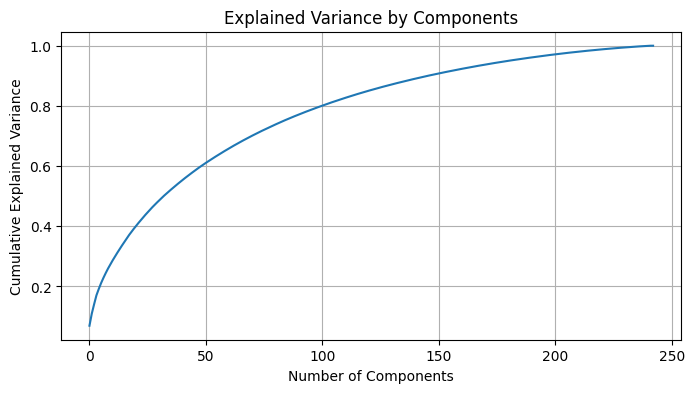

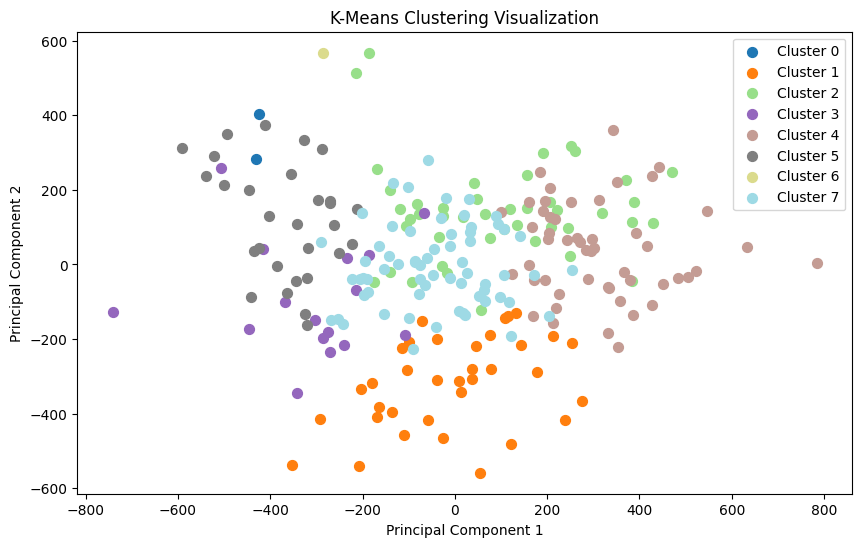

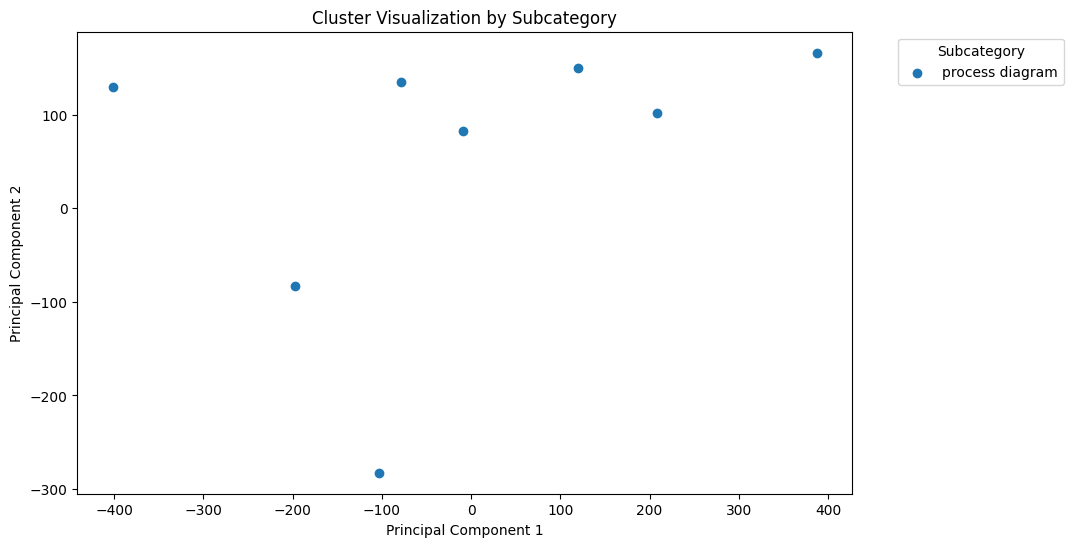

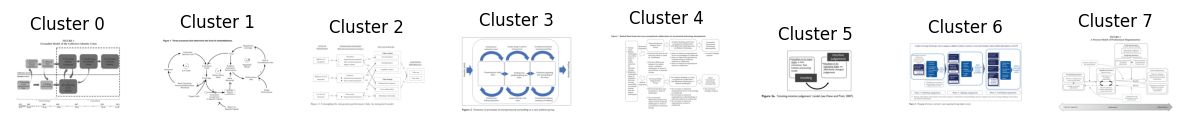

Subcategory,process diagram
Cluster,
0,2
1,35
2,44
3,16
4,51
5,29
6,1
7,65


In [2]:
# Define the years range and the list to store data from each year
years = range(2000, 2023)
dataframes = []
clustering_types = ["process diagram"]

for year in years:
    file_path = f"../cropped_and_labeled_image_data/{year}_cropped_and_labeled_figs.xlsx"
    yearly_figure_data = pd.read_excel(file_path)
    
    # Filter data for specific subcategories
    current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
    
    # Remove duplicate entries based on 'original paper' and 'subcategory'
    current_yearly_data = current_yearly_data.drop_duplicates(subset=['original paper', 'subcategory'])
    
    # Append the processed data to the list
    dataframes.append(current_yearly_data)

# Concatenate all the dataframes into one
all_data = pd.concat(dataframes, ignore_index=True)

print(f"Figure count in selected subcategories: {all_data.shape[0]}")
if(all_data.shape[0] > 2):
    features_flattened, pca, image_paths = get_image_variance(all_data)
    # Create directories for clusters
    base_dir = f'../clustered_images/all/process diagram'
    labels, subcategories, closest_images = reduce_create_visualize_save_cluters(all_data, features_flattened, image_paths, base_dir, pca, cluster_count = 8)
    ## display closest images
    display_closest_images(closest_images, base_dir)
    ## Show counts of figure types in each cluster
    cluster_data = pd.DataFrame({
        'Cluster': labels,
        'Subcategory': subcategories
    })
    # Create a pivot table to count subcategories in each cluster
    subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
    display(subcategory_counts)

## Conceptual Diagrams
Save 20 most representative per each cluster

Figure count in selected subcategories: 207
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step


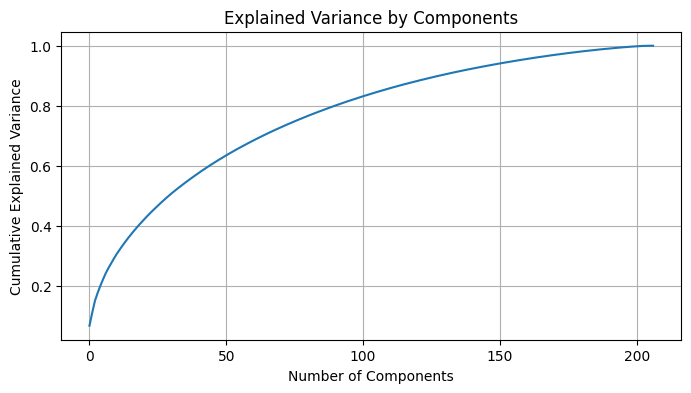

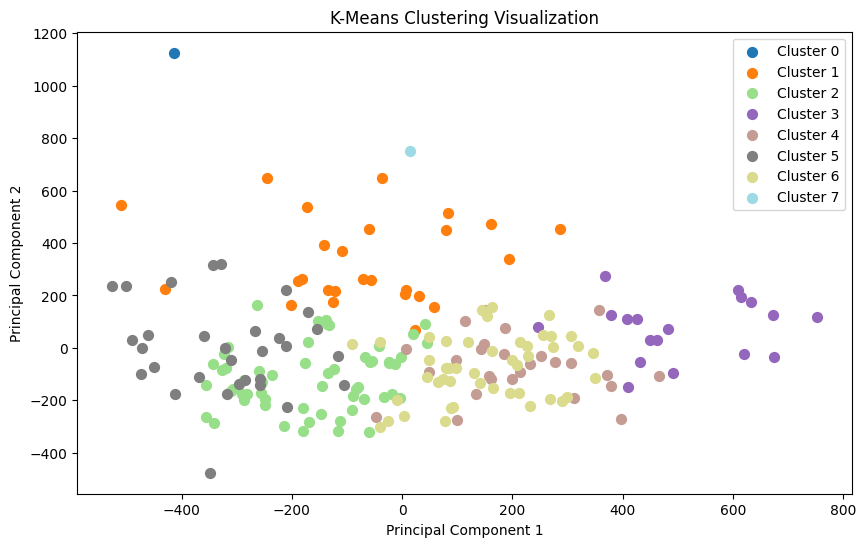

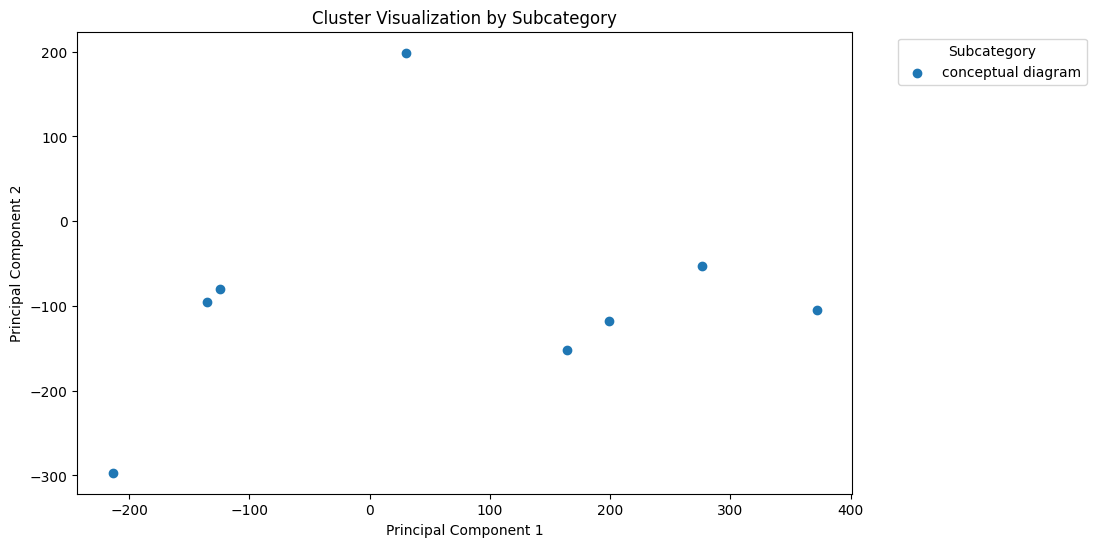

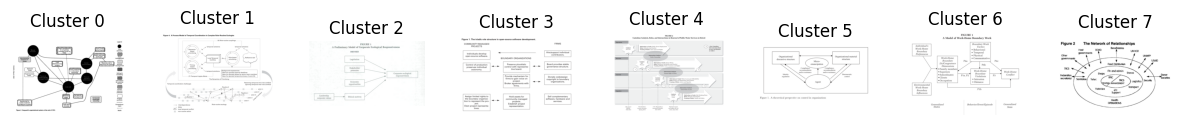

Subcategory,conceptual diagram
Cluster,
0,1
1,26
2,57
3,19
4,26
5,31
6,46
7,1


In [3]:
# Define the years range and the list to store data from each year
years = range(2000, 2023)
dataframes = []
clustering_types = ["conceptual diagram"]

for year in years:
    file_path = f"../cropped_and_labeled_image_data/{year}_cropped_and_labeled_figs.xlsx"
    yearly_figure_data = pd.read_excel(file_path)
    
    # Filter data for specific subcategories
    current_yearly_data = yearly_figure_data[yearly_figure_data["subcategory"].isin(clustering_types)]
    
    # Remove duplicate entries based on 'original paper' and 'subcategory'
    current_yearly_data = current_yearly_data.drop_duplicates(subset=['original paper', 'subcategory'])
    
    # Append the processed data to the list
    dataframes.append(current_yearly_data)

# Concatenate all the dataframes into one
all_data = pd.concat(dataframes, ignore_index=True)

print(f"Figure count in selected subcategories: {all_data.shape[0]}")
if(all_data.shape[0] > 2):
    features_flattened, pca, image_paths = get_image_variance(all_data)
    # Create directories for clusters
    base_dir = f'../clustered_images/all/conceptual diagram'
    labels, subcategories, closest_images = reduce_create_visualize_save_cluters(all_data, features_flattened, image_paths, base_dir, pca, cluster_count = 8)
    ## display closest images
    display_closest_images(closest_images, base_dir)
    ## Show counts of figure types in each cluster
    cluster_data = pd.DataFrame({
        'Cluster': labels,
        'Subcategory': subcategories
    })
    # Create a pivot table to count subcategories in each cluster
    subcategory_counts = pd.pivot_table(cluster_data, index='Cluster', columns='Subcategory', aggfunc='size', fill_value=0)
    display(subcategory_counts)